# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import torch
import torch.nn as nn
import torch.optim as optim

# Загрузка данных

In [46]:
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')
data = pd.concat([red_wine, white_wine], axis=0)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

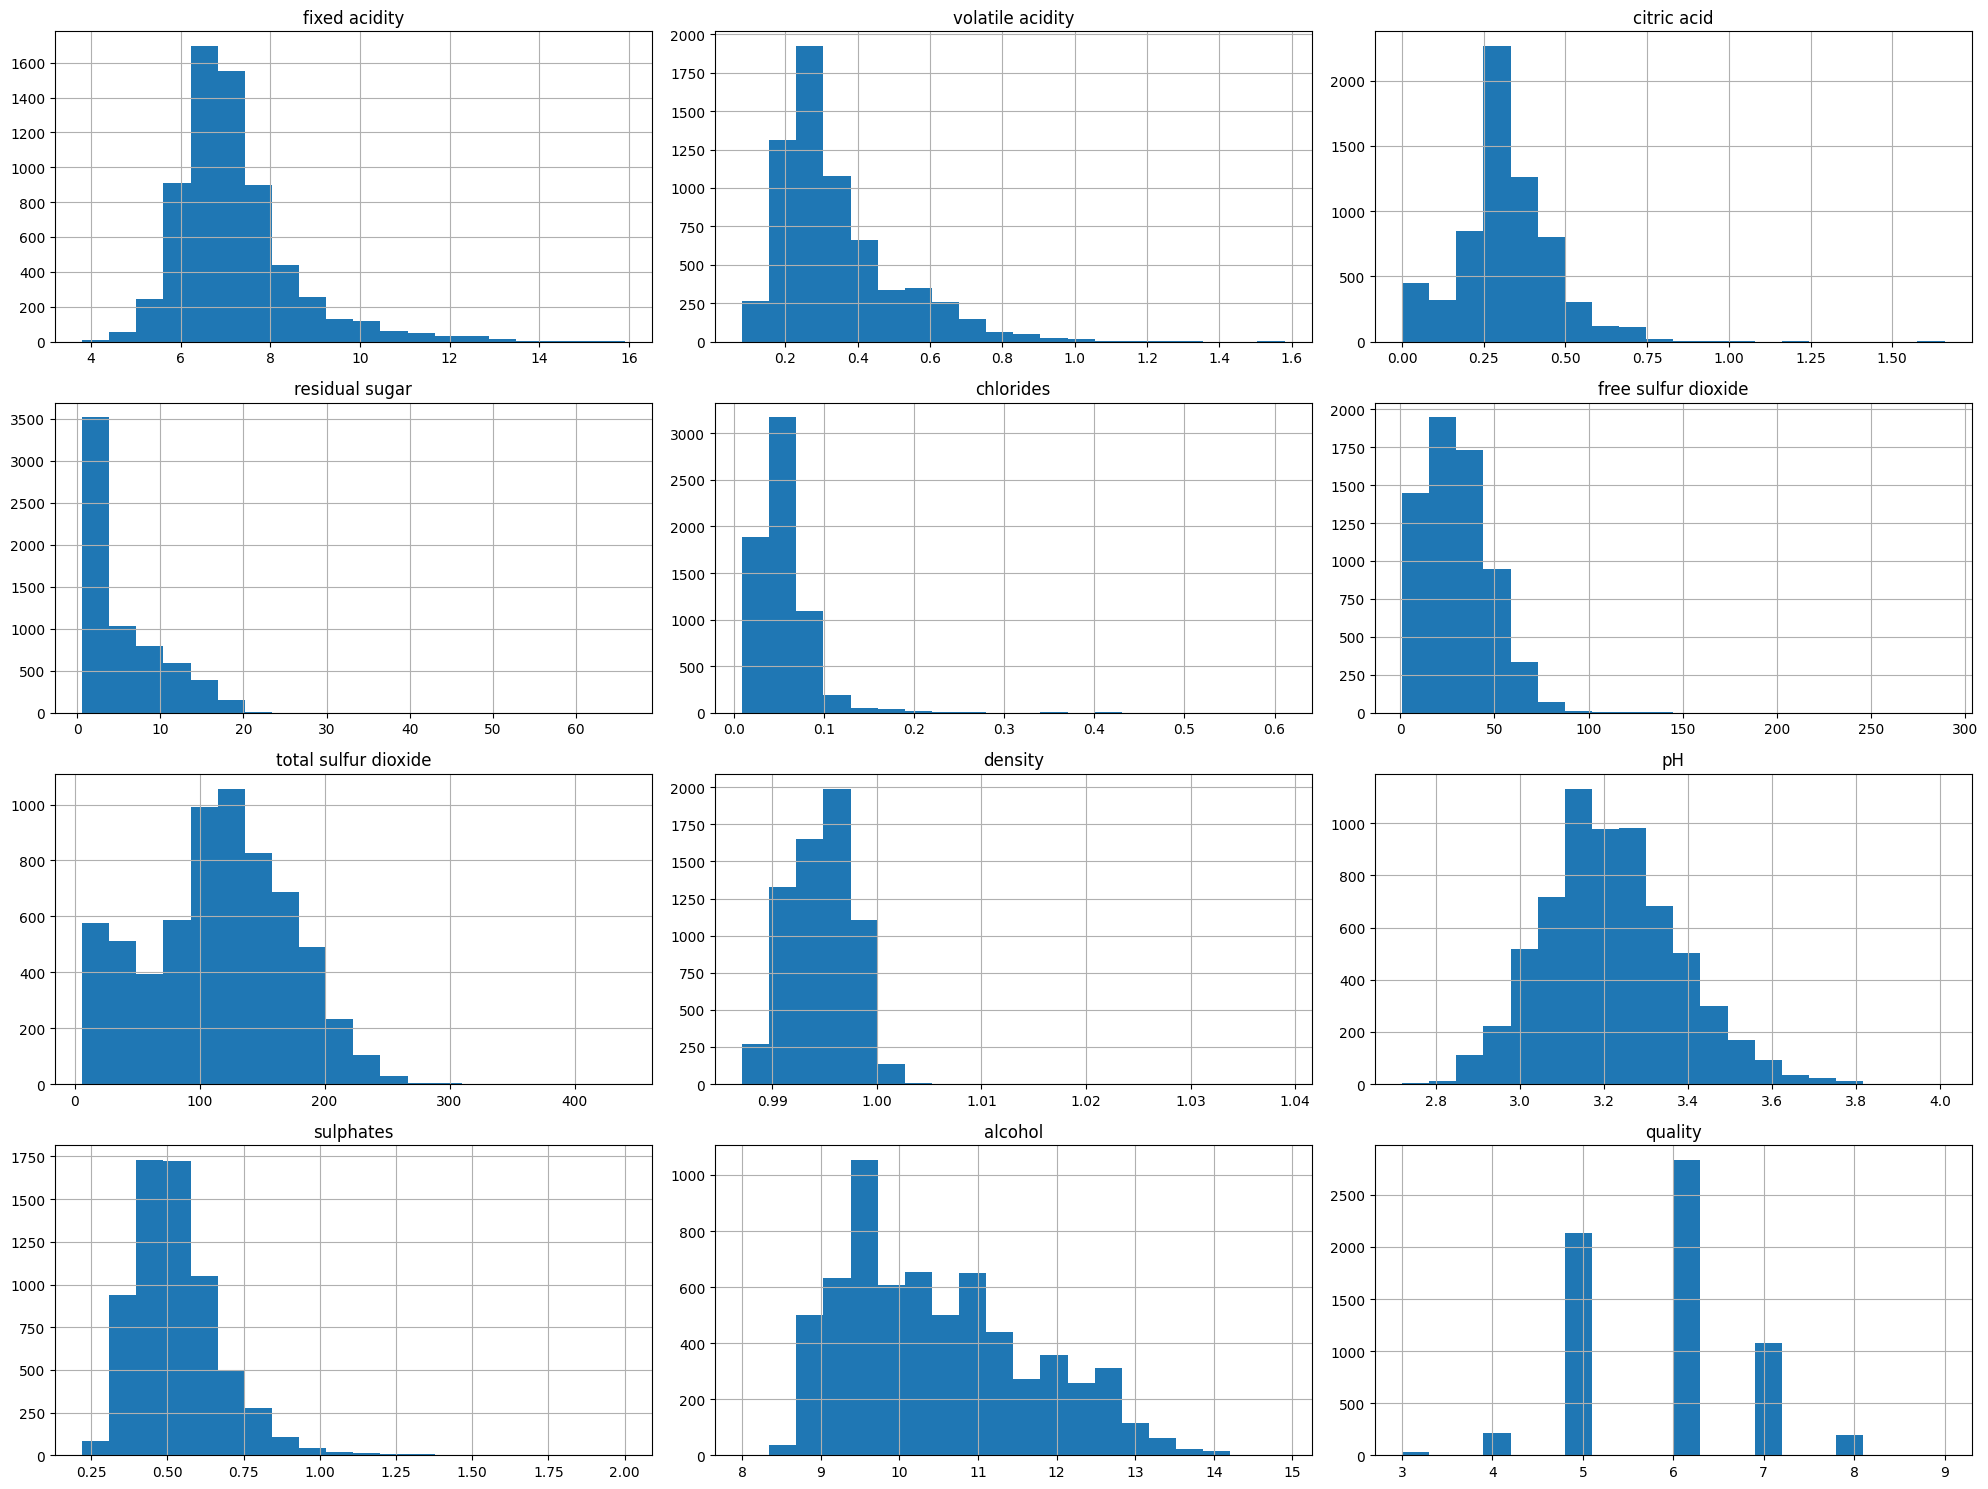

In [50]:
# Основные характеристики данных
print(data.describe())

# Гистограммы распределения для каждого признака
data.hist(bins=20, figsize=(20, 15), layout=(4, 3))
plt.tight_layout()
plt.show()

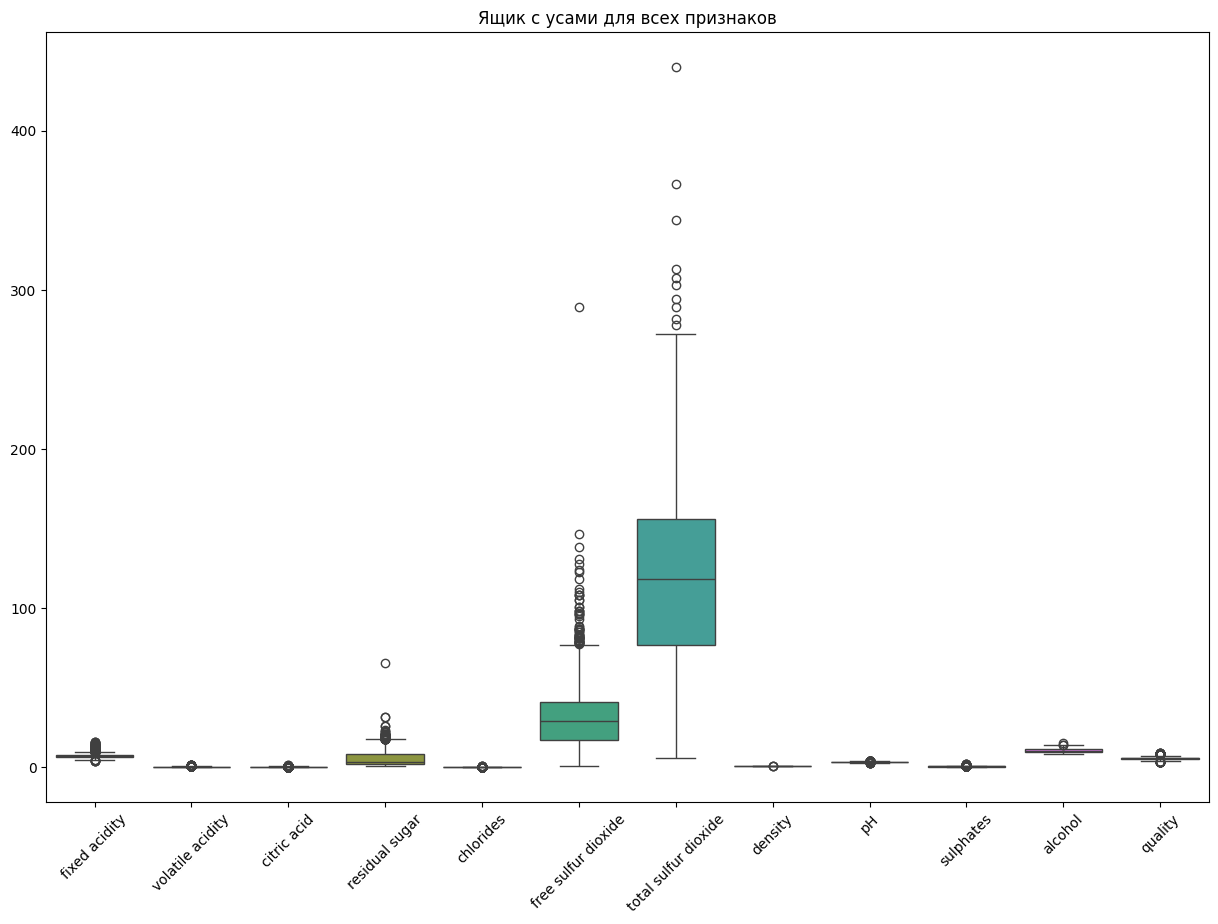

In [13]:
# Ящик с усами для выявления выбросов
plt.figure(figsize=(15, 10))
sns.boxplot(data=data)
plt.xticks(rotation=45)
plt.title('Ящик с усами для всех признаков')
plt.show()

# Нормализация данных

In [ ]:
scaler = StandardScaler()
features = data.columns[:-1]
data[features] = scaler.fit_transform(data[features])

In [ ]:
X = data[features]
y = data['quality']

# CatBoost без учета весов классов + GridSearch (для подбора лучших параметров)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(loss_function='RMSE', verbose=0)

param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'CatBoost с подобранными гиперпараметрами R²: {r2:.2f}, MAE: {mae:.2f}')

Лучшие параметры: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CatBoost с подобранными гиперпараметрами R²: 0.49, MAE: 0.44


# CatBoost с учетом весов для классов (для учета дисбаланса классов) + GridSearch (для подбора лучших параметров)

In [ ]:
# Вычисление весов для каждого экземпляра на основе классов
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

# Разделение данных с учетом весов
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

model = CatBoostRegressor(loss_function='RMSE', verbose=0)

param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# GridSearchCV с учетом весов
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train, sample_weight=weights_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'CatBoost с учетом дисбаланса классов R²: {r2:.2f}, MAE: {mae:.2f}')

Лучшие параметры: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CatBoost с учетом дисбаланса классов R²: 0.43, MAE: 0.47


In [ ]:
# Важность признаков
importances = best_model.feature_importances_
print(importances)

[ 5.99609354 10.0385908   7.09686236  8.39849915  8.5928941  14.50094227
  8.69029147  7.84078933  6.28426021  5.55860178 17.00217498]


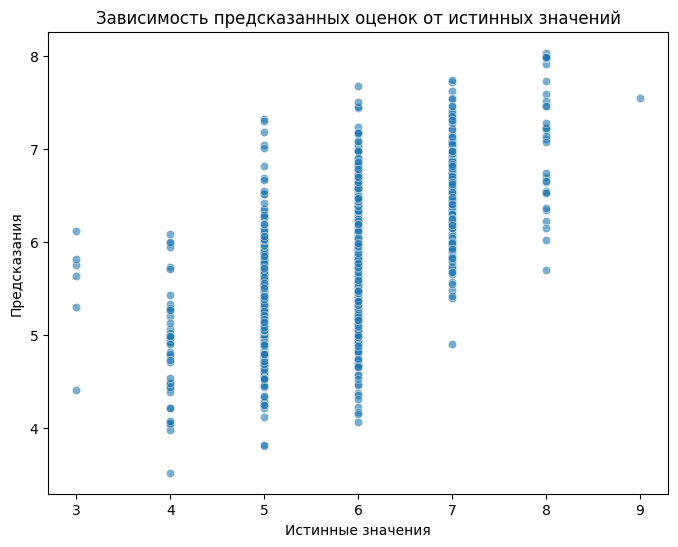

In [58]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.title('Зависимость предсказанных оценок от истинных значений')
plt.show()

# FeedForward нейронка + Dropout (0.5)

In [ ]:
X = X.to_numpy()
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class WineQualityNN(nn.Module):
    def __init__(self):
        super(WineQualityNN, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        return self.output(x)

model = WineQualityNN()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Нейронная сеть R²: {r2:.2f}, MAE: {mae:.2f}')

Epoch [100/5000], Loss: 1.3122
Epoch [200/5000], Loss: 0.5664
Epoch [300/5000], Loss: 0.5319
Epoch [400/5000], Loss: 0.5168
Epoch [500/5000], Loss: 0.5161
Epoch [600/5000], Loss: 0.5112
Epoch [700/5000], Loss: 0.4972
Epoch [800/5000], Loss: 0.4895
Epoch [900/5000], Loss: 0.4900
Epoch [1000/5000], Loss: 0.4812
Epoch [1100/5000], Loss: 0.4645
Epoch [1200/5000], Loss: 0.4687
Epoch [1300/5000], Loss: 0.4608
Epoch [1400/5000], Loss: 0.4533
Epoch [1500/5000], Loss: 0.4546
Epoch [1600/5000], Loss: 0.4552
Epoch [1700/5000], Loss: 0.4415
Epoch [1800/5000], Loss: 0.4371
Epoch [1900/5000], Loss: 0.4349
Epoch [2000/5000], Loss: 0.4299
Epoch [2100/5000], Loss: 0.4339
Epoch [2200/5000], Loss: 0.4303
Epoch [2300/5000], Loss: 0.4268
Epoch [2400/5000], Loss: 0.4278
Epoch [2500/5000], Loss: 0.4183
Epoch [2600/5000], Loss: 0.4160
Epoch [2700/5000], Loss: 0.4220
Epoch [2800/5000], Loss: 0.4168
Epoch [2900/5000], Loss: 0.4203
Epoch [3000/5000], Loss: 0.4148
Epoch [3100/5000], Loss: 0.4098
Epoch [3200/5000]

# Случайный лес с подбором параметров

In [66]:
# Настройка гиперпараметров для RandomForest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Используем GridSearchCV для RandomForest
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=100)
grid_rf.fit(X_train, y_train)
rf_best_model = grid_rf.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 4/5; 1/36] START max_depth=None, min_samples_split=2, n_estimators=100......
[CV 1/5; 2/36] START max_depth=None, min_samples_split=2, n_estimators=200......
[CV 2/5; 1/36] START max_depth=None, min_samples_split=2, n_estimators=100......
[CV 3/5; 1/36] START max_depth=None, min_samples_split=2, n_estimators=100......
[CV 1/5; 1/36] START max_depth=None, min_samples_split=2, n_estimators=100......
[CV 2/5; 2/36] START max_depth=None, min_samples_split=2, n_estimators=200......
[CV 3/5; 2/36] START max_depth=None, min_samples_split=2, n_estimators=200......
[CV 5/5; 1/36] START max_depth=None, min_samples_split=2, n_estimators=100......
[CV 1/5; 1/36] END max_depth=None, min_samples_split=2, n_estimators=100;, score=0.509 total time=   1.6s
[CV 2/5; 1/36] END max_depth=None, min_samples_split=2, n_estimators=100;, score=0.478 total time=   1.6s
[CV 4/5; 2/36] START max_depth=None, min_samples_split=2, n_estimators=200....

In [68]:
# Настройка гиперпараметров для MLPRegressor
param_grid_mlp = {
    'hidden_layer_sizes': [(128, 64), (64, 32, 16), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [1000]
}


# Используем GridSearchCV для MLPRegressor
grid_mlp = GridSearchCV(MLPRegressor(random_state=42), param_grid_mlp, cv=5, scoring='r2', n_jobs=-1)
grid_mlp.fit(X_train, y_train)
mlp_best_model = grid_mlp.best_estimator_

/Users/dmitrijvarlygin/Documents/ML_Projects/test_task_hubr/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dmitrijvarlygin/Documents/ML_Projects/test_task_hubr/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dmitrijvarlygin/Documents/ML_Projects/test_task_hubr/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dmitrijvarlygin/Documents/ML_Projects/test_task_hubr/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:205: RuntimeWarning: over

# Оценка моделей: Random Forest, MLPRegressor (R², MAE)

In [67]:
# Оценка моделей на тестовой выборке
y_pred_rf = rf_best_model.predict(X_test)
print(f"RandomForest R²: {r2_score(y_test, y_pred_rf):.2f}")
print(f"RandomForest MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")

RandomForest R²: 0.50
RandomForest MAE: 0.44


In [69]:
y_pred_mlp = mlp_best_model.predict(X_test)
print(f"MLP Regressor R²: {r2_score(y_test, y_pred_mlp):.2f}")
print(f"MLP Regressor MAE: {mean_absolute_error(y_test, y_pred_mlp):.2f}")

MLP Regressor R²: 0.40
MLP Regressor MAE: 0.53
